## Verifying treecorr patch stochasiticity's effect on jackknife

- Defining patches in catalogue affects resulting values due to different numerical realization
- Stochasticity in patches has significant bearing on resulting tangential shear values of similar order to 
    signal magnitude 

In [1]:
import numpy as np
import treecorr
import des_functions as des
from more_itertools import locate
import time
import astropy.io.fits as fits 
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
data_dir = '/home/b7009348/WGL_project/DES-data/'

In [4]:
#des.create_patches(lens_file=lens_file, npatches=npatches)

Patches saved, runtime=1.197099.


In [2]:
lens_file = 'DES_Y1A1_Lenses_z=0.3-0.45.fits'
rand_file = 'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits'
im3_file = 'y1_im3_shapes_matched.fits'
mcal_file = 'y1_mcal_shapes_matched.fits'
z_file = 'mcal_BPZ_(binning).fits'

In [17]:
tests = 5
npatches= 20
num_bins = [20, 25, 30, 35]
theta_min = 2.5
theta_max = 250.0

Catalogues saved, runtime=29.846627.
Patch 0 located and sliced, calculating correlations...
IA signal estimated, runtime=102.425046.
Patch 1 located and sliced, calculating correlations...
IA signal estimated, runtime=194.933373.
Patch 2 located and sliced, calculating correlations...
IA signal estimated, runtime=208.327811.
Patch 3 located and sliced, calculating correlations...
IA signal estimated, runtime=216.607795.
Patch 4 located and sliced, calculating correlations...
IA signal estimated, runtime=217.790090.
Patch 5 located and sliced, calculating correlations...
IA signal estimated, runtime=217.288340.
Patch 6 located and sliced, calculating correlations...
IA signal estimated, runtime=285.106143.
Patch 7 located and sliced, calculating correlations...
IA signal estimated, runtime=115.356243.
Patch 8 located and sliced, calculating correlations...
IA signal estimated, runtime=115.294838.
Patch 9 located and sliced, calculating correlations...
IA signal estimated, runtime=111.7

IndexError: list index out of range

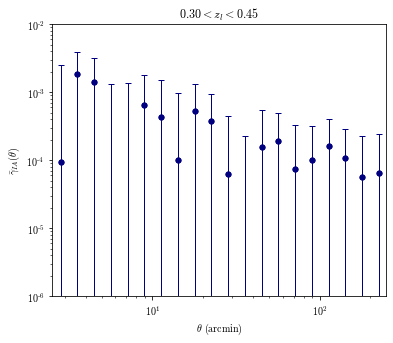

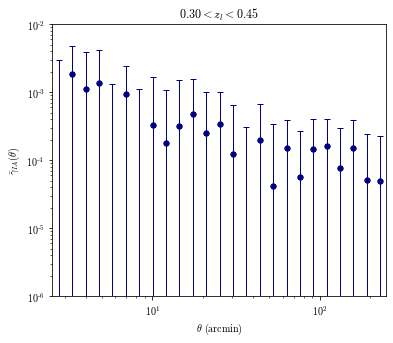

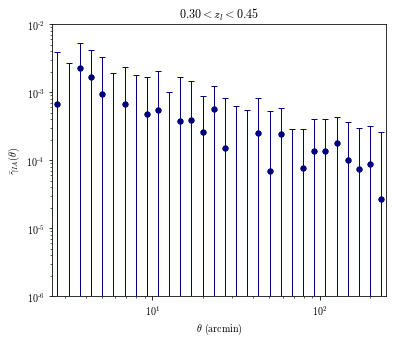

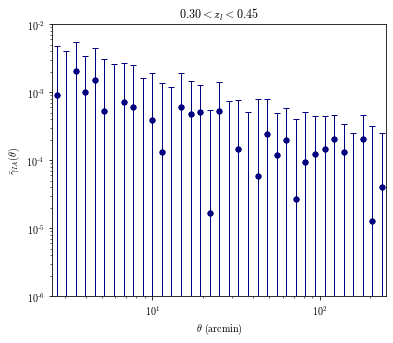

In [18]:
for i in range(tests):
    
    sep_bins = num_bins[i]

    start=time.time()
    
    with fits.open(data_dir+lens_file) as hdu:
        data = hdu[1].data
        ra_l = data['RA']
        dec_l = data['DEC']
        w_l = data['weight']
    del data

    cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, patch_centers=data_dir+'jackknife_patch_centers')

    del ra_l, dec_l, w_l

    with fits.open(data_dir+rand_file) as hdu:
        data = hdu[1].data
        indexes = list(locate(data['z'], lambda x: 0.3 < x < 0.45))
        ra_r = data['RA'][indexes]
        dec_r = data['DEC'][indexes]
        rand_z = data['z'][indexes]
    del data

    cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg', r=rand_z, patch_centers=data_dir+'jackknife_patch_centers')

    del indexes, ra_r, dec_r, rand_z

    with fits.open(data_dir+mcal_file) as hdu:
        data = hdu[1].data
        ra_s = data['ra']
        dec_s = data['dec']
        e1 = data['e1']
        e2 = data['e2']
        R11 = data['R11']
    del data

    cat_mcal = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', r=R11, g1=e1, g2=e2, patch_centers=data_dir+'jackknife_patch_centers')

    del ra_s, dec_s, e1, e2, R11

    with fits.open(data_dir+im3_file) as hdu:
        data = hdu[1].data
        im3_ID = data['coadd_objects_id']
        ra_s = data['ra']
        dec_s = data['dec']
        e1 = data['e1'] - data['c1']
        e2 = data['e2'] - data['c2']
        sens = data['m'] + 1.0
        w = data['weight']
    del data

    with fits.open(data_dir+z_file) as hdu:
        data = hdu[1].data
        zmc = data['z_mc']
        zmc_ID = data['coadd_objects_id']
    del data

    matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

    zmc = zmc[zmc_indices]

    del zmc_ID, matches, zmc_indices, shape_indices, im3_ID

    cat_im3 = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', r=zmc, g1=e1, g2=e2, w=w, 
                               patch_centers=data_dir+'jackknife_patch_centers')
    cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', k=sens, w=w, patch_centers=data_dir+'jackknife_patch_centers')

    del ra_s, dec_s, e1, e2, sens, zmc, w

    end = time.time()
    diff=end-start

    print('Catalogues saved, runtime=%f.'%diff)

    IA_jk, IA_sig = des.IA_jackknife(cat_l=cat_l, cat_r=cat_r, cat_mcal=cat_mcal, cat_im3=cat_im3, cat_k=cat_k, sep_bins=sep_bins, npatches=npatches, fbins=810,
                                    theta_min=theta_min, theta_max=theta_max)

    IA_final, theta = des.IA_full(cat_l=cat_l, cat_r=cat_r, cat_mcal=cat_mcal, cat_im3=cat_im3, cat_k=cat_k, sep_bins=sep_bins, fbins=810, 
                                  theta_min=theta_min, theta_max=theta_max)
    
    print(IA_final, IA_sig)                            

    plt.figure(figsize=[6,5])
    plt.errorbar(theta, IA_final, yerr=IA_sig, lw=0, marker='o', color='navy', markersize=5, elinewidth=1, capsize=3)
    plt.plot(theta, IA_final, lw=0, marker='o', color='navy', markersize=5)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([1e-6, 1e-2])
    plt.xlim([2.5,250])
    plt.xlabel(r'$\theta$ (arcmin)')
    plt.ylabel(r'$\bar{\gamma}_{IA}(\theta)$')
    plt.title(r'$0.30<z_{l}<0.45$')
    plt.savefig('IA_catalogues_test_%d.png'%i, dpi=300)
    
    del cat_l, cat_r, cat_im3, cat_mcal, cat_k

/home/b7009348/WGL_project/wgl_project/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/b7009348/WGL_project/wgl_project/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


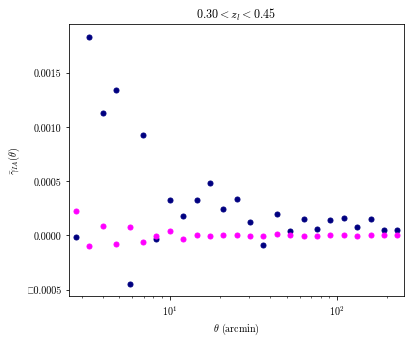

In [12]:
tang_diff = [ 2.25216715e-04, -9.33544294e-05,  8.88774963e-05, -7.74507453e-05,
   8.01284590e-05, -5.64505564e-05, -8.17272317e-06,  3.99394931e-05,
  -3.33759152e-05,  3.56881789e-06, -3.99462135e-06, -3.65421816e-07,
   4.46929623e-06, -7.88178034e-06, -6.88180043e-06,  1.23299015e-05,
   8.25911181e-07, -1.90613108e-06, -1.69997659e-06,  1.09231949e-06,
   1.15966323e-06, -3.35098045e-06,  4.87223298e-07, -3.11915407e-07,
   1.80940485e-06]

plt.figure(figsize=[6,5])
#plt.errorbar(theta, IA_final, yerr=IA_sig, lw=0, marker='o', color='navy', markersize=5, elinewidth=1, capsize=3)
plt.plot(theta, IA_final, lw=0, marker='o', color='navy', markersize=5)
plt.plot(theta, tang_diff, lw=0, marker='o', color='magenta', markersize=5)
#plt.yscale('log')
plt.xscale('log')
#plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$\bar{\gamma}_{IA}(\theta)$')
plt.title(r'$0.30<z_{l}<0.45$')
plt.savefig('IA_vs_PatchOffset.png', dpi=300)